In [3]:
#importing the libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

In [59]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,),)])

trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data',download=True,
                                train=True, transform = transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data',download=True,
                                train=False, transform = transform)

indices = list(range(len(trainset)))
np.random.shuffle(indices)

split = int(np.floor(0.2*len(trainset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

train_loader = torch.utils.data.DataLoader(trainset, sampler = train_sample, batch_size = 100)
valid_loader = torch.utils.data.DataLoader(trainset, sampler = valid_sample, batch_size = 100)
test_loader = torch.utils.data.DataLoader(testset, batch_size = 100, shuffle=True)

In [136]:
class FashionCNN(nn.Module):
    
    
    def __init__(self): 
        super(FashionCNN, self).__init__() 
        self.layer1 = nn.Sequential( 
                                    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2), 
                                    nn.LeakyReLU(),  
                                    nn.AvgPool2d(kernel_size=2, stride=2), 
                                    )
        self.layer2 = nn.Sequential( 
                                    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1), 
                                    nn.LeakyReLU(),  
                                    nn.AvgPool2d(kernel_size=2, stride=2), 
                                   ) 
        self.layer3 = nn.Sequential( 
                                    nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
                                    nn.LeakyReLU(), 
                                   )
        self.layer4 = nn.Sequential( 
                                    nn.Linear(in_features=120, out_features=84),
                                    nn.LeakyReLU(), 
                                    nn.Linear(in_features=84, out_features=10),
                                   )
        self.soft = nn.Softmax(dim=1)
        
        
    def forward(self, x): 
        x_out = self.layer1(x) 
        x_out = self.layer2(x_out)
        x_out = self.layer3(x_out)
        x_out = x_out.reshape(x_out.size(0), -1) 
        x_out = self.layer4(x_out)

        return x_out
    

In [158]:
model = FashionCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)


valid_loss_min = np.Inf
epochs = 40
steps = 0
model.train()
train_losses, valid_losses = [],[]

for e in range(epochs):
    running_loss = 0
    valid_loss = 0
    
    for images, labels in train_loader:
        
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*images.size(0)
    
    for images, labels in valid_loader:
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        valid_loss += loss.item()*images.size(0)
    
    running_loss = running_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(running_loss)
    valid_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(e+1,
                                                                               running_loss,
                                                                               valid_loss))


Epoch: 1 	Training Loss: 2.304047 	Validation Loss: 2.300949
Epoch: 2 	Training Loss: 2.298072 	Validation Loss: 2.294298
Epoch: 3 	Training Loss: 2.289306 	Validation Loss: 2.282895
Epoch: 4 	Training Loss: 2.268022 	Validation Loss: 2.243710
Epoch: 5 	Training Loss: 2.142798 	Validation Loss: 1.939591
Epoch: 6 	Training Loss: 1.526321 	Validation Loss: 1.156702
Epoch: 7 	Training Loss: 0.997679 	Validation Loss: 0.933913
Epoch: 8 	Training Loss: 0.876207 	Validation Loss: 0.804571
Epoch: 9 	Training Loss: 0.804953 	Validation Loss: 0.773086
Epoch: 10 	Training Loss: 0.781996 	Validation Loss: 0.786582
Epoch: 11 	Training Loss: 0.752439 	Validation Loss: 0.763085
Epoch: 12 	Training Loss: 0.726937 	Validation Loss: 0.716437
Epoch: 13 	Training Loss: 0.715914 	Validation Loss: 0.755175
Epoch: 14 	Training Loss: 0.696960 	Validation Loss: 0.739947
Epoch: 15 	Training Loss: 0.685011 	Validation Loss: 0.678898
Epoch: 16 	Training Loss: 0.666668 	Validation Loss: 0.684969
Epoch: 17 	Traini

<function matplotlib.pyplot.legend(*args, **kwargs)>

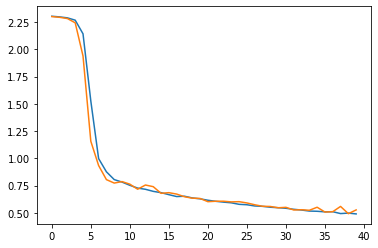

In [159]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')

plt.legend

In [160]:
test_loss = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
ims,lbls,outs,out_pr,out_act = [],[],[],[],[]

model.eval()
for images, labels in test_loader:
    output = model(images)
    
    for i in range(labels.size(0)):
            outs.append(output[i])
            ims.append(images[i])
            lbls.append(labels[i])
            
    loss = criterion(output, labels)
    test_loss += loss.item()*images.size(0)
    max_val, pred = torch.max(output,1)
    for i in range(labels.size(0)):
        out_pr.append(max_val[i])
        out_act.append(output[i][labels[i]])

    correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
    for i in range(len(labels)):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] +=1

test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)'%(str(i), 100 * class_correct[i]/class_total[i],np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A(no training examples)' % classes[i])
            
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct)/np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.552773

Test Accuracy of     0: 79% (796/1000)
Test Accuracy of     1: 91% (919/1000)
Test Accuracy of     2: 63% (632/1000)
Test Accuracy of     3: 89% (895/1000)
Test Accuracy of     4: 85% (852/1000)
Test Accuracy of     5: 87% (874/1000)
Test Accuracy of     6: 16% (165/1000)
Test Accuracy of     7: 93% (930/1000)
Test Accuracy of     8: 93% (935/1000)
Test Accuracy of     9: 94% (948/1000)

Test Accuracy (Overall): 79% (7946/10000)


In [161]:
def show_worst(ims, lbls, outs, out_pr, out_act):
    _, worst10 = torch.topk(torch.abs(torch.Tensor(out_pr) - torch.Tensor(out_act)), 10)
    fig, axes = plt.subplots(2,5)
    for i in range(len(axes)):
        for j in range(len(axes[0])):
            idx = worst10[i*len(axes[0]) + j]
            axes[i, j].imshow(ims[idx].cpu().reshape((28,28)) , cmap = 'gray')
            axes[i, j].set_title("Actual: "+ str(round(lbls[idx].item(), 10)) + "\n" + 
                                 "Predicted: " + str(round(torch.argmax(outs[idx]).item(), 10)))
    fig.suptitle("Worst predictions", fontsize=16)
    fig.set_figheight(8)
    fig.set_figwidth(15)
    fig.tight_layout()

In [162]:
def show_best(ims, lbls, outs, out_pr, out_act):
    _, best10 = torch.topk(torch.Tensor(out_pr), 10)
    fig, axes = plt.subplots(2,5, sharex=True, sharey=True)
    for i in range(len(axes)):
        for j in range(len(axes[0])):
            idx = best10[i*len(axes[0]) + j]
            axes[i, j].imshow(ims[idx].cpu().reshape((28,28)) , cmap = 'gray')
            axes[i, j].set_title("Actual: "+ str(round(lbls[idx].item(), 10)) + "\n" + 
                                 "Predicted: " + str(round(torch.argmax(outs[idx]).item(), 10)))
    fig.suptitle("Best predictions", fontsize=16)
    fig.set_figheight(8)
    fig.set_figwidth(15)
    fig.tight_layout()

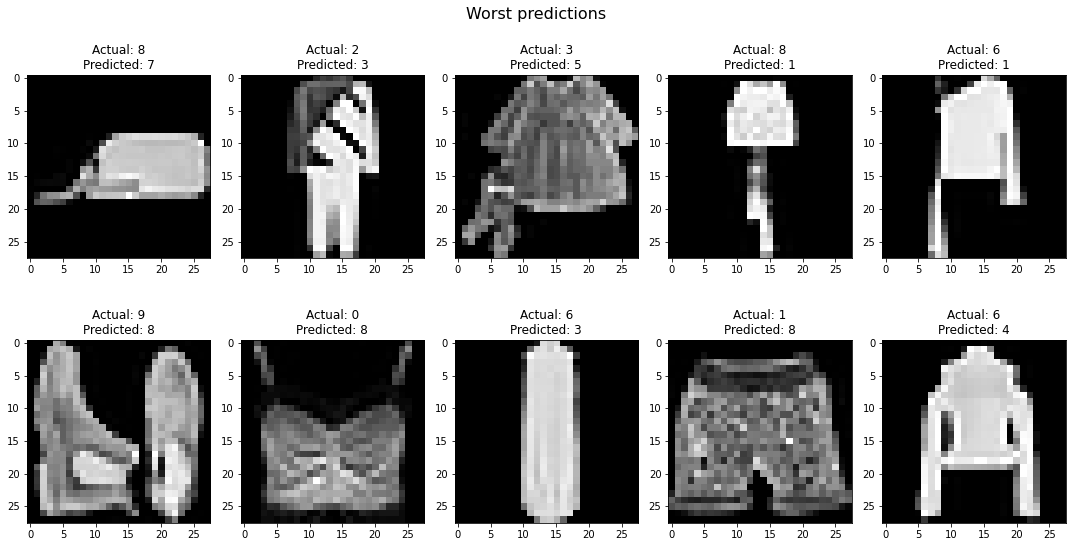

In [163]:
show_worst(ims, lbls, outs, out_pr, out_act)

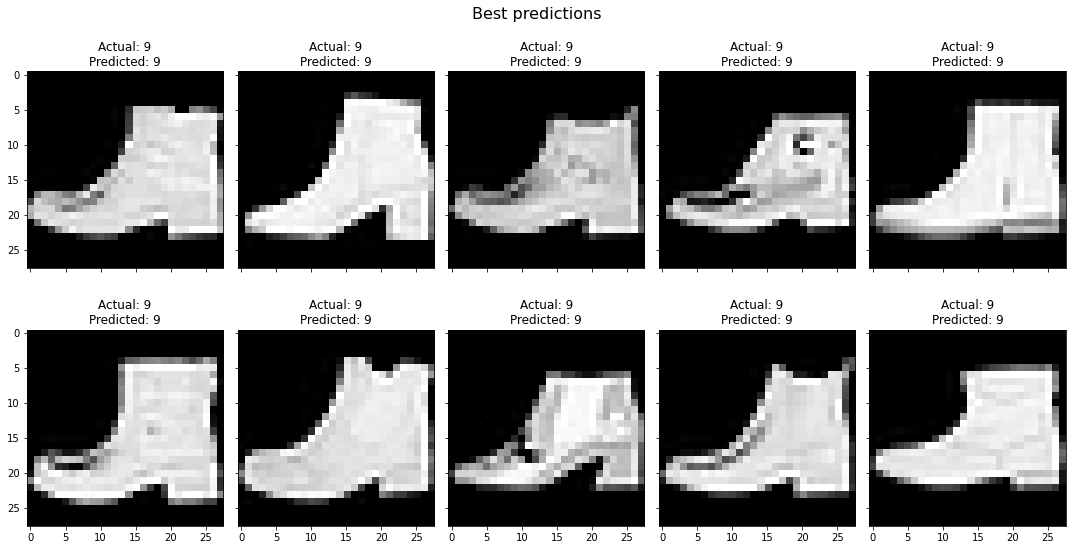

In [164]:
show_best(ims, lbls, outs, out_pr, out_act)

In [165]:
import torch.onnx
dummy_d = torch.randn(1, 1, 28, 28, requires_grad=True)
torch.onnx.export(model, dummy_d, "lenet5_model1.onnx", input_names=["input"], output_names=["output"])

In [166]:
class FashionLeNet_2(nn.Module):
    
    def __init__(self): 
        super(FashionLeNet_2, self).__init__() 
        self.layer1 = nn.Sequential( 
                                    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),
                                    nn.LeakyReLU(),  
                                    nn.MaxPool2d(kernel_size=2, stride=2), 
                                    )
        self.layer2 = nn.Sequential( 
                                    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
                                    nn.LeakyReLU(),  
                                    nn.MaxPool2d(kernel_size=2, stride=2), 
                                   )
        self.layer3 = nn.Sequential( 
                                    nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
                                    nn.LeakyReLU(), 
                                   )
        self.layer4 = nn.Sequential( 
                                    nn.Linear(in_features=120, out_features=84),
                                    nn.LeakyReLU(), 
                                    nn.Linear(in_features=84, out_features=10),
                                   )
        self.soft = nn.Softmax(dim=1)
        
        
    def forward(self, x): 
        x_out = self.layer1(x) 
        x_out = self.layer2(x_out)
        x_out = self.layer3(x_out)
        x_out = x_out.reshape(x_out.size(0), -1) 
        x_out = self.layer4(x_out)
        return x_out

In [167]:
model = FashionLeNet_2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

valid_loss_min = np.Inf
epochs = 40
steps = 0
model.train()
train_losses, valid_losses = [],[]

for e in range(epochs):
    running_loss = 0
    valid_loss = 0
    
    for images, labels in train_loader:
        
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*images.size(0)
        
        
    
    for images, labels in valid_loader:
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        valid_loss += loss.item()*images.size(0)
    
    running_loss = running_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(running_loss)
    valid_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(e+1,
                                                                               running_loss,
                                                                               valid_loss))

Epoch: 1 	Training Loss: 2.297409 	Validation Loss: 2.289862
Epoch: 2 	Training Loss: 2.277596 	Validation Loss: 2.261789
Epoch: 3 	Training Loss: 2.221746 	Validation Loss: 2.149497
Epoch: 4 	Training Loss: 1.843417 	Validation Loss: 1.376170
Epoch: 5 	Training Loss: 1.060114 	Validation Loss: 0.862695
Epoch: 6 	Training Loss: 0.814562 	Validation Loss: 0.775480
Epoch: 7 	Training Loss: 0.739126 	Validation Loss: 0.717418
Epoch: 8 	Training Loss: 0.698355 	Validation Loss: 0.688387
Epoch: 9 	Training Loss: 0.668657 	Validation Loss: 0.677444
Epoch: 10 	Training Loss: 0.641577 	Validation Loss: 0.640942
Epoch: 11 	Training Loss: 0.631036 	Validation Loss: 0.666774
Epoch: 12 	Training Loss: 0.614586 	Validation Loss: 0.621465
Epoch: 13 	Training Loss: 0.598925 	Validation Loss: 0.587346
Epoch: 14 	Training Loss: 0.586070 	Validation Loss: 0.575868
Epoch: 15 	Training Loss: 0.577415 	Validation Loss: 0.600888
Epoch: 16 	Training Loss: 0.567350 	Validation Loss: 0.556073
Epoch: 17 	Traini

<function matplotlib.pyplot.legend(*args, **kwargs)>

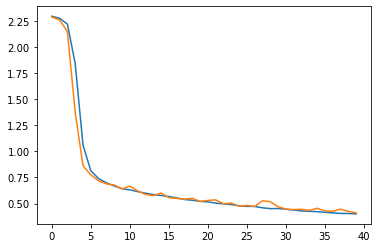

In [168]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')

plt.legend

In [169]:
test_loss = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
ims,lbls,outs,out_pr,out_act = [],[],[],[],[]

model.eval()
for images, labels in test_loader:
    output = model(images)
    
    for i in range(labels.size(0)):
            outs.append(output[i])
            ims.append(images[i])
            lbls.append(labels[i])
            
    loss = criterion(output, labels)
    test_loss += loss.item()*images.size(0)
    max_val, pred = torch.max(output,1)
    for i in range(labels.size(0)):
        out_pr.append(max_val[i])
        out_act.append(output[i][labels[i]])

    correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
    for i in range(len(labels)):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] +=1

test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)'%(str(i), 100 * class_correct[i]/class_total[i],np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A(no training examples)' % classes[i])
            
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct)/np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.435350

Test Accuracy of     0: 72% (723/1000)
Test Accuracy of     1: 95% (959/1000)
Test Accuracy of     2: 71% (715/1000)
Test Accuracy of     3: 83% (838/1000)
Test Accuracy of     4: 77% (779/1000)
Test Accuracy of     5: 93% (934/1000)
Test Accuracy of     6: 63% (636/1000)
Test Accuracy of     7: 93% (932/1000)
Test Accuracy of     8: 95% (952/1000)
Test Accuracy of     9: 95% (954/1000)

Test Accuracy (Overall): 84% (8422/10000)


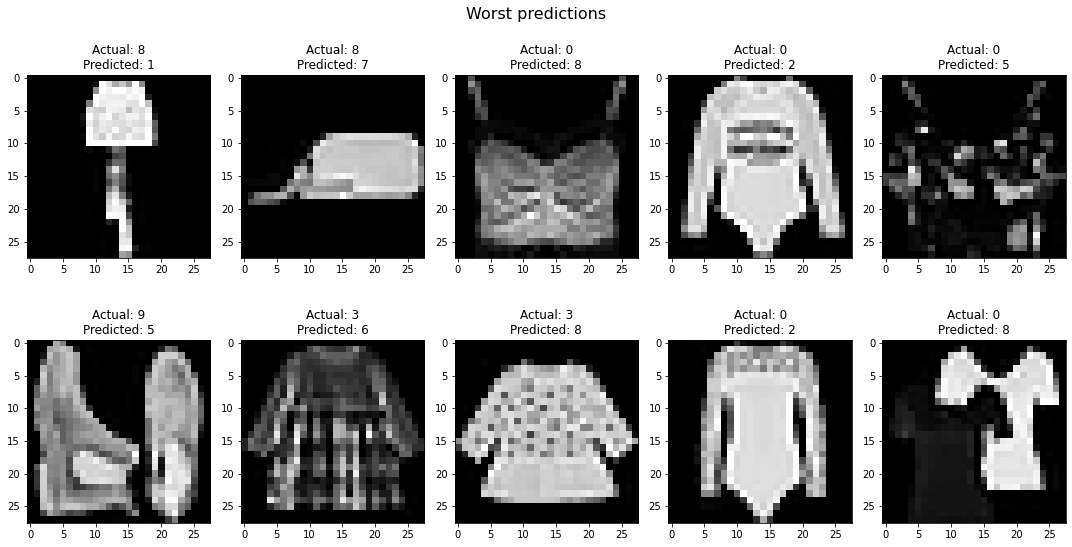

In [170]:
show_worst(ims, lbls, outs, out_pr, out_act)

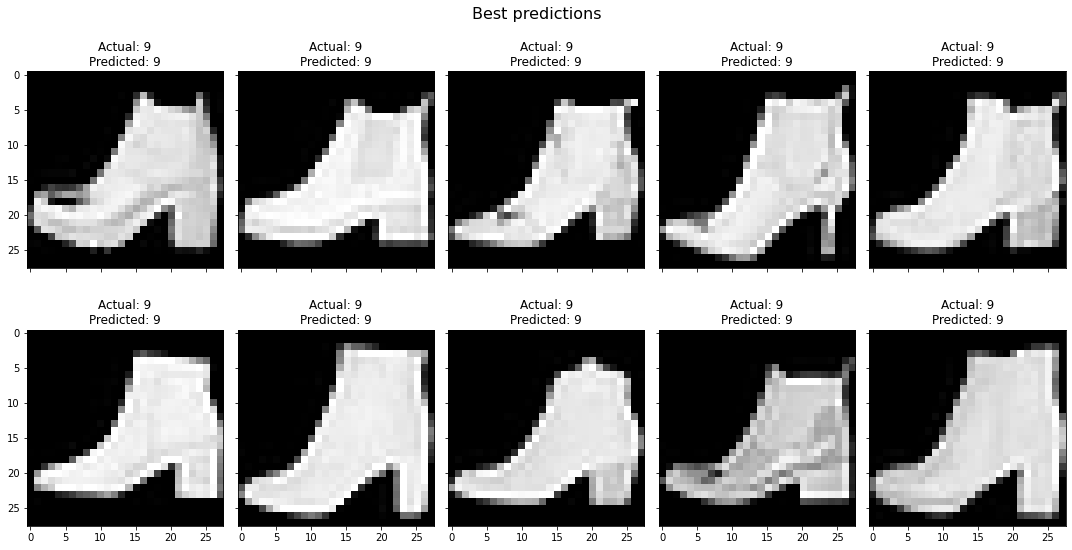

In [171]:
show_best(ims, lbls, outs, out_pr, out_act)

In [172]:
dummy_d = torch.randn(1, 1, 28, 28, requires_grad=True)
torch.onnx.export(model, dummy_d, "lenet5_model2.onnx", input_names=["input"], output_names=["output"])